In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
img_array = cv2.imread("\\train\\angry\\Training_3908.jpg")

In [3]:
print(img_array.shape)

(48, 48, 3)


In [4]:
cv2.imread("\\train\\angry\\Training_33331.jpg")

array([[[136, 136, 136],
        [168, 168, 168],
        [222, 222, 222],
        ...,
        [212, 212, 212],
        [194, 194, 194],
        [191, 191, 191]],

       [[135, 135, 135],
        [185, 185, 185],
        [224, 224, 224],
        ...,
        [225, 225, 225],
        [193, 193, 193],
        [193, 193, 193]],

       [[144, 144, 144],
        [206, 206, 206],
        [224, 224, 224],
        ...,
        [236, 236, 236],
        [197, 197, 197],
        [192, 192, 192]],

       ...,

       [[165, 165, 165],
        [173, 173, 173],
        [193, 193, 193],
        ...,
        [174, 174, 174],
        [168, 168, 168],
        [193, 193, 193]],

       [[192, 192, 192],
        [141, 141, 141],
        [150, 150, 150],
        ...,
        [160, 160, 160],
        [175, 175, 175],
        [187, 187, 187]],

       [[204, 204, 204],
        [207, 207, 207],
        [133, 133, 133],
        ...,
        [154, 154, 154],
        [180, 180, 180],
        [176, 176, 176]]

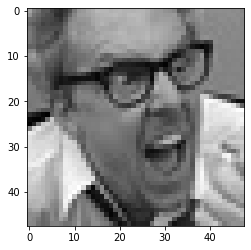

In [5]:
plt.imshow(img_array)
plt.show()

In [6]:
Traindirectory = "C:\\Users\Kaja Rutkowska\OneDrive - McKinsey & Company\\Documents\\Studia - BIG DATA\\NOWY PROJEKT\\archive (1)\\train\\"
Testdirectory = "C:\\Users\Kaja Rutkowska\OneDrive - McKinsey & Company\\Documents\\Studia - BIG DATA\\NOWY PROJEKT\\archive (1)\\test\\"

In [7]:
Classes = ["angry", "happy", "disgust", "fear", "sad", "neutral", "suprise"]

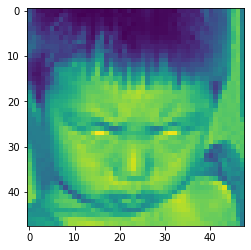

In [8]:
for category in Classes:
    path = os.path.join(Traindirectory, category)
    for img in os.listdir(path):
        image_path = os.path.join(path,img)
        image = cv2.imread(image_path, 0)
        image = np.expand_dims(image, 2)
        image = (image - 127.5)/127.5
      
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY))
        plt.imshow(image)
        break
    break

In [9]:
train_data_gen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2,
    validation_split =0.2
)

test_data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

In [10]:
train_data = train_data_gen.flow_from_directory(
    directory=Traindirectory,
    target_size= (48,38), 
    batch_size=64,
    color_mode='rgb',
    class_mode='sparse'
)

Found 28709 images belonging to 7 classes.


In [11]:
test_data = test_data_gen.flow_from_directory(
    directory= Testdirectory,
    target_size= (48,48), 
    batch_size=64,
    color_mode='rgb',
    class_mode='sparse'
)

Found 7178 images belonging to 7 classes.


In [12]:
in_sh = (48,48,3)
w = 'imagenet'

FER_base_model = tf.keras.applications.resnet50.ResNet50(input_shape= in_sh,include_top = False, weights = w)


FER_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [13]:
emotion_model = Sequential()

emotion_model.add(FER_base_model)
emotion_model.add(Dropout(0.5))
emotion_model.add(Flatten())
emotion_model.add(BatchNormalization())

In [16]:
emotion_model.add(Dense(512, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(0.01)))
emotion_model.add(Dense(256, activation='relu'))
emotion_model.add(Dense(128, activation='relu'))
emotion_model.add(Dropout(rate = 0.2))
emotion_model.add(Dense(64, activation='relu'))
emotion_model.add(Dense(7, activation='softmax'))

In [18]:
print(emotion_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [19]:
opt = keras.optimizers.Adam()
loss = 'sparse_categorical_crossentropy'
met = 'accuracy'
emotion_model.compile(loss= loss ,optimizer=opt, metrics=[met])


In [20]:
emotion_model.fit(
    train_data,
    batch_size = 32,
    verbose = "auto",
    epochs=60,
    validation_data=test_data
)

Epoch 1/60
449/449 [==============================] - 1298s 3s/step - loss: 2.0370 - accuracy: 0.2599 - val_loss: 1.9134 - val_accuracy: 0.2471
Epoch 2/60
449/449 [==============================] - 1278s 3s/step - loss: 1.8572 - accuracy: 0.2720 - val_loss: 1.9653 - val_accuracy: 0.2471
Epoch 3/60
449/449 [==============================] - 1271s 3s/step - loss: 1.8041 - accuracy: 0.2859 - val_loss: 1.8264 - val_accuracy: 0.2718
Epoch 4/60
449/449 [==============================] - 1253s 3s/step - loss: 1.7891 - accuracy: 0.2891 - val_loss: 1.8472 - val_accuracy: 0.2590
Epoch 5/60
449/449 [==============================] - 1249s 3s/step - loss: 1.7588 - accuracy: 0.2969 - val_loss: 1.8004 - val_accuracy: 0.2725
Epoch 6/60
449/449 [==============================] - 1227s 3s/step - loss: 1.7061 - accuracy: 0.3172 - val_loss: 1.7244 - val_accuracy: 0.3051
Epoch 7/60
449/449 [==============================] - 1234s 3s/step - loss: 1.6232 - accuracy: 0.3505 - val_loss: 1.8643 - val_accuracy:

In [21]:
emotions_dict = {0 : 'angry', 1 :'disguse',2 :'fear',3:'happy',4 :'neutral',5:'sad',6:'surprised'}

In [22]:
x_test,y_test = next(test_data)
predictions = emotion_model.predict(test_data)


In [23]:
y_pred = np.argmax(predictions, axis=1)

In [24]:
num_rows = 5
num_cols = 3

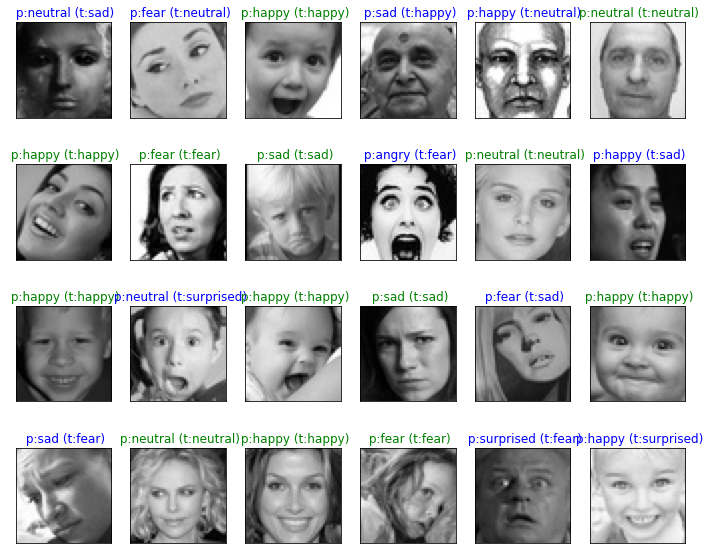

In [35]:
figure = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i, index in enumerate(np.random.choice(x_test.shape[1], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[index])
    prediction_index = emotions_dict[(np.argmax(predictions[index]))]
    true_index = emotions_dict[(y_test[index])]
    ax.set_title(" p:{} (t:{})".format((prediction_index), 
                                  (true_index)),
                                  color=("green" if prediction_index == true_index else "blue"))

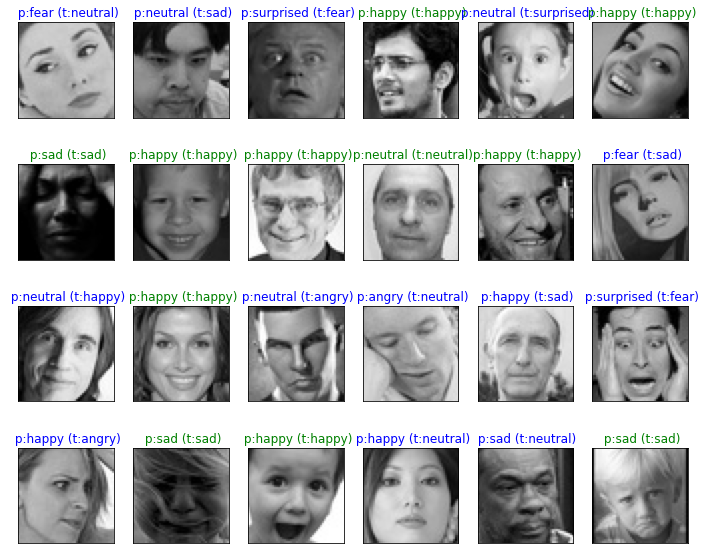

In [36]:
figure = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i, index in enumerate(np.random.choice(x_test.shape[1], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[index])
    prediction_index = emotions_dict[(np.argmax(predictions[index]))]
    true_index = emotions_dict[(y_test[index])]
    ax.set_title(" p:{} (t:{})".format((prediction_index), 
                                  (true_index)),
                                  color=("green" if prediction_index == true_index else "blue"))

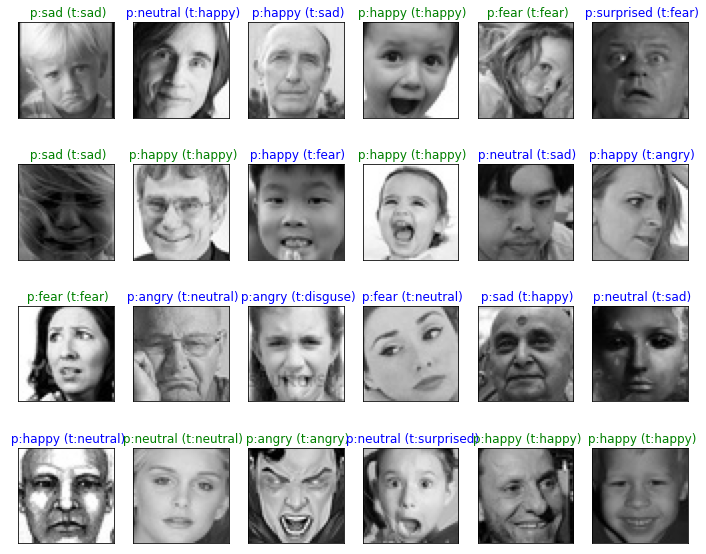

In [38]:
figure = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i, index in enumerate(np.random.choice(x_test.shape[1], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[index])
    prediction_index = emotions_dict[(np.argmax(predictions[index]))]
    true_index = emotions_dict[(y_test[index])]
    ax.set_title(" p:{} (t:{})".format((prediction_index), 
                                  (true_index)),
                                  color=("green" if prediction_index == true_index else "blue"))

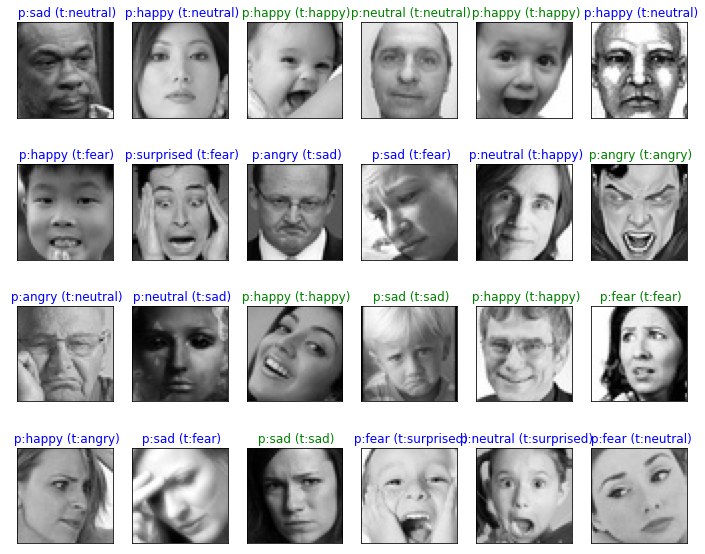

In [39]:
figure = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i, index in enumerate(np.random.choice(x_test.shape[1], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[index])
    prediction_index = emotions_dict[(np.argmax(predictions[index]))]
    true_index = emotions_dict[(y_test[index])]
    ax.set_title(" p:{} (t:{})".format((prediction_index), 
                                  (true_index)),
                                  color=("green" if prediction_index == true_index else "blue"))

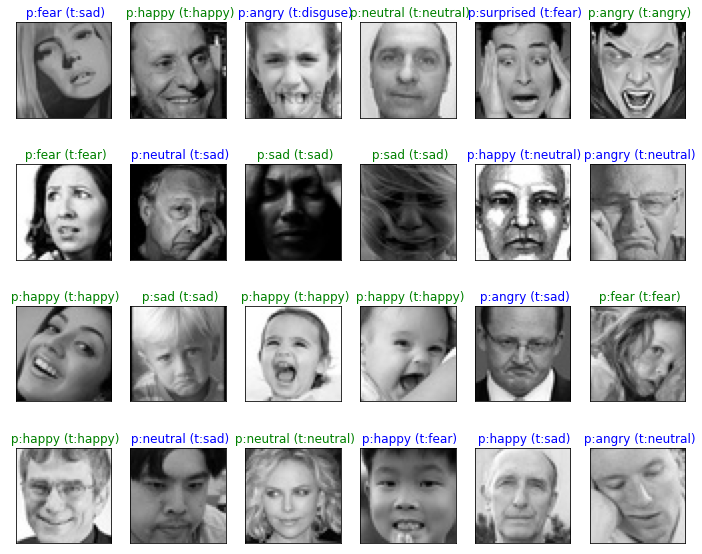

In [37]:
figure = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i, index in enumerate(np.random.choice(x_test.shape[1], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[index])
    prediction_index = emotions_dict[(np.argmax(predictions[index]))]
    true_index = emotions_dict[(y_test[index])]
    ax.set_title(" p:{} (t:{})".format((prediction_index), 
                                  (true_index)),
                                  color=("green" if prediction_index == true_index else "blue"))

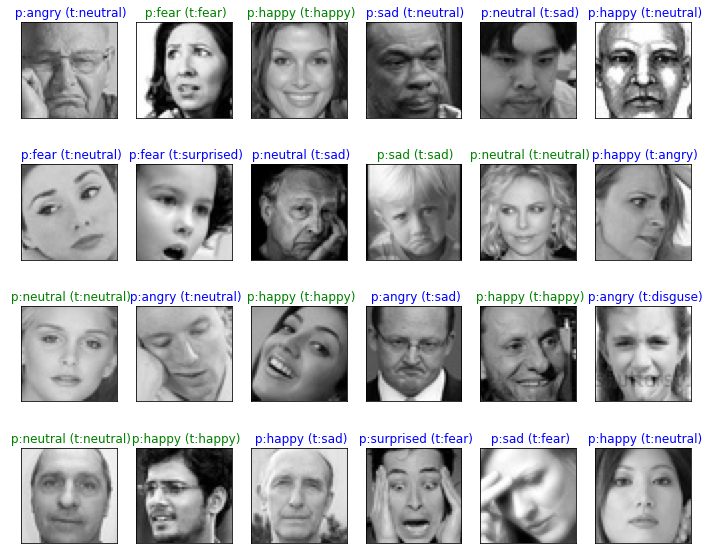

In [26]:
figure = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i, index in enumerate(np.random.choice(x_test.shape[1], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[index])
    prediction_index = emotions_dict[(np.argmax(predictions[index]))]
    true_index = emotions_dict[(y_test[index])]
    ax.set_title(" p:{} (t:{})".format((prediction_index), 
                                  (true_index)),
                                  color=("green" if prediction_index == true_index else "blue"))

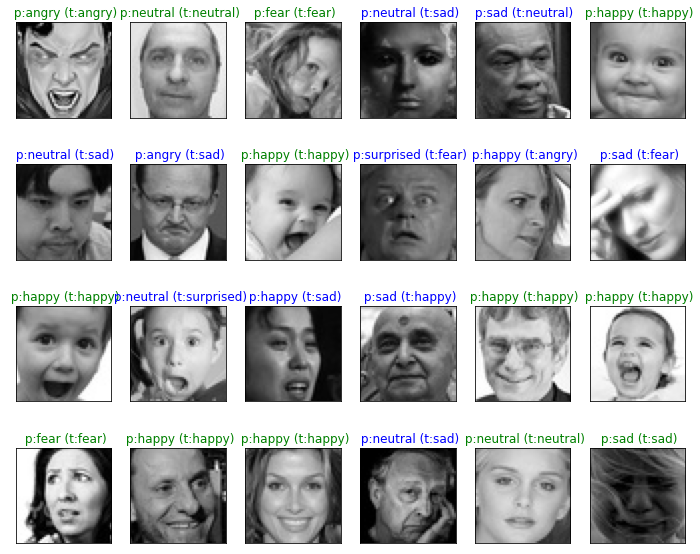

In [27]:
figure = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i, index in enumerate(np.random.choice(x_test.shape[1], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[index])
    prediction_index = emotions_dict[(np.argmax(predictions[index]))]
    true_index = emotions_dict[(y_test[index])]
    ax.set_title(" p:{} (t:{})".format((prediction_index), 
                                  (true_index)),
                                  color=("green" if prediction_index == true_index else "blue"))

In [28]:
df = pd.DataFrame(predictions)
df.columns = ['ANGRY', 'DISGUSE','FEAR','HAPPY','NEUTRAL', 'SAD','SUPRISED']

In [29]:
df['PREDICTED_EMOTION'] = y_pred
df = df.replace({"PREDICTED_EMOTION": emotions_dict})

In [30]:
prediction_index = emotions_dict[(np.argmax(predictions[index]))]

In [31]:
print(df)

         angry   disguse      fear     happy   neutral       sad  surprised  \
0     0.134910  0.010452  0.095800  0.427809  0.157090  0.151747   0.022193   
1     0.134632  0.006797  0.126712  0.111496  0.322355  0.277262   0.020746   
2     0.131472  0.006861  0.115498  0.080859  0.361611  0.287812   0.015887   
3     0.106442  0.008165  0.231396  0.260224  0.061189  0.051779   0.280806   
4     0.124155  0.009407  0.087916  0.462314  0.154541  0.140002   0.021664   
...        ...       ...       ...       ...       ...       ...        ...   
7173  0.118856  0.005015  0.114396  0.122802  0.375935  0.239845   0.023151   
7174  0.010836  0.000494  0.007693  0.937837  0.025522  0.007537   0.010082   
7175  0.009871  0.000432  0.006975  0.942912  0.023552  0.006739   0.009519   
7176  0.418167  0.100066  0.223245  0.007749  0.031525  0.208274   0.010974   
7177  0.070292  0.006563  0.357234  0.031255  0.065904  0.047152   0.421599   

     predicted_emotion  
0                happy  
1

In [32]:
y_actual = test_data.classes[test_data.index_array]
df2 = pd.DataFrame(y_actual)
df2.columns = ["EMOTION"]
df2 = df2.replace({"EMOTION": emotions_dict})
print(df2)

        EMOTION
0       neutral
1         angry
2     surprised
3         happy
4         angry
...         ...
7173        sad
7174       fear
7175       fear
7176  surprised
7177    neutral

[7178 rows x 1 columns]


In [33]:
final_results = pd.merge(df, df2, left_index=True, right_index=True)
print(final_results)

         angry   disguse      fear     happy   neutral       sad  surprised  \
0     0.134910  0.010452  0.095800  0.427809  0.157090  0.151747   0.022193   
1     0.134632  0.006797  0.126712  0.111496  0.322355  0.277262   0.020746   
2     0.131472  0.006861  0.115498  0.080859  0.361611  0.287812   0.015887   
3     0.106442  0.008165  0.231396  0.260224  0.061189  0.051779   0.280806   
4     0.124155  0.009407  0.087916  0.462314  0.154541  0.140002   0.021664   
...        ...       ...       ...       ...       ...       ...        ...   
7173  0.118856  0.005015  0.114396  0.122802  0.375935  0.239845   0.023151   
7174  0.010836  0.000494  0.007693  0.937837  0.025522  0.007537   0.010082   
7175  0.009871  0.000432  0.006975  0.942912  0.023552  0.006739   0.009519   
7176  0.418167  0.100066  0.223245  0.007749  0.031525  0.208274   0.010974   
7177  0.070292  0.006563  0.357234  0.031255  0.065904  0.047152   0.421599   

     predicted_emotion    EMOTION  
0              

In [34]:
final_results.to_csv('my_data.csv')